In [22]:
import os
import pathlib
import ssl

import matplotlib.pyplot as plt
import numpy as np
import PIL
from   PIL import Image
import tensorflow as tf
from   tensorflow.keras import Sequential
from   tensorflow.keras.layers import (
    Conv2D, Dense, Flatten, MaxPooling2D as Pool, Rescaling)
from   tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_datasets as tfds


ssl._create_default_https_context = ssl._create_unverified_context
tf.__version__

'2.6.0'

In [2]:
dataset_url = (
    'https://storage.googleapis.com/download.tensorflow.org/'
    'example_images/flower_photos.tgz')
data_dir = tf.keras.utils.get_file(
    origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
img_count = len(list(data_dir.glob('*/*.jpg')))
img_count

3670

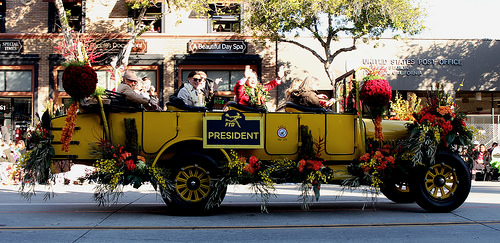

In [4]:
roses = list(data_dir.glob('roses/*'))
Image.open(str(roses[0]))

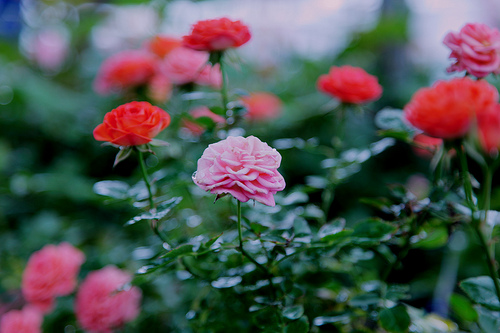

In [5]:
Image.open(str(roses[1]))

In [6]:
BATCH = 32
IMG_H = IMG_W = 180

In [7]:
train = image_dataset_from_directory(data_dir,
                                     validation_split=0.2,
                                     subset='training', 
                                     seed=1107,
                                     image_size=(IMG_H, IMG_W),
                                     batch_size=BATCH)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
valid = image_dataset_from_directory(data_dir,
                                     validation_split=0.2,
                                     subset='validation',
                                     seed=24,
                                     image_size=(IMG_H, IMG_W),
                                     batch_size=BATCH)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

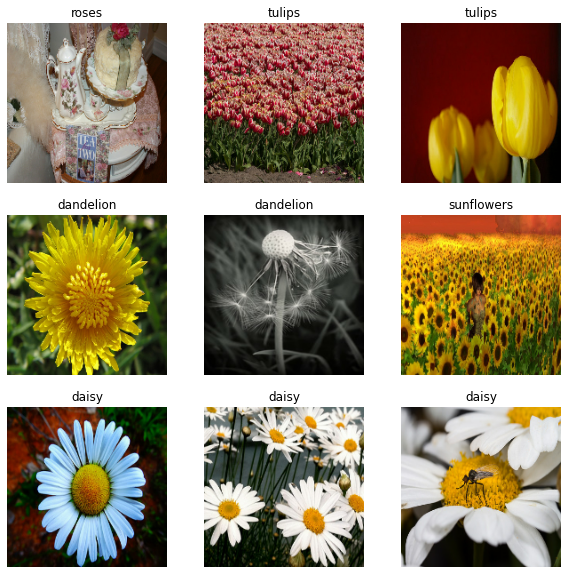

In [10]:
plt.figure(figsize=[10, 10])
for imgs, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
for img_batch, label_batch in train:
    print(img_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Standardize

In [13]:
norm_layer = Rescaling(1 / 255.)

In [15]:
normed_ds = train.map(lambda x, y: (norm_layer(x), y))
img_batch, label_batch = next(iter(normed_ds))
first_img = img_batch[0]

In [17]:
np.min(first_img), np.max(first_img)

(0.0, 0.9995934)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

In [19]:
train = train.cache().prefetch(buffer_size=AUTOTUNE)
valid = valid.cache().prefetch(buffer_size=AUTOTUNE)

### Train

In [20]:
N_CLASSES = 5

In [23]:
mod = Sequential([Rescaling(1 / 255.),
                  Conv2D(32, 3, activation='relu'),
                  Pool(),
                  Conv2D(32, 3, activation='relu'),
                  Pool(),
                  Conv2D(32, 3, activation='relu'),
                  Pool(),
                  Flatten(),
                  Dense(128, activation='relu'),
                  Dense(N_CLASSES)])

In [24]:
mod.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [25]:
mod.fit(train, validation_data=valid, epochs=3)

Epoch 1/3
92/92 [==============================] - 43s 456ms/step - loss: 1.3019 - accuracy: 0.4349 - val_loss: 1.1213 - val_accuracy: 0.5109
Epoch 2/3
92/92 [==============================] - 41s 442ms/step - loss: 1.0470 - accuracy: 0.5787 - val_loss: 0.9683 - val_accuracy: 0.6471
Epoch 3/3
92/92 [==============================] - 41s 440ms/step - loss: 0.8666 - accuracy: 0.6683 - val_loss: 0.7601 - val_accuracy: 0.7248


### `tf.data` for finer control

In [26]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(img_count, reshuffle_each_iteration=False)

In [27]:
for f in list_ds.take(5):
    print(f.numpy())

b'/Users/dsatterthwaite/.keras/datasets/flower_photos/roses/5223191368_01aedb6547_n.jpg'
b'/Users/dsatterthwaite/.keras/datasets/flower_photos/tulips/2834890466_1cf220fba1.jpg'
b'/Users/dsatterthwaite/.keras/datasets/flower_photos/roses/9369421752_db1ab2a6a4_m.jpg'
b'/Users/dsatterthwaite/.keras/datasets/flower_photos/roses/2960709681_e95940c0f0_n.jpg'
b'/Users/dsatterthwaite/.keras/datasets/flower_photos/roses/5628552852_60bbe8d9b0_n.jpg'


In [28]:
class_names = np.array(
    sorted([item.name for item in data_dir.glob('*') 
            if item.name != 'LICENSE.txt']))
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [29]:
val_size = int(img_count * 0.2)
train = list_ds.skip(val_size)
valid = list_ds.take(val_size)

In [30]:
[tf.data.experimental.cardinality(x).numpy() for x in (train, valid)]

[2936, 734]

In [31]:
def get_label(path):
    parts = tf.strings.split(path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [32]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [IMG_H, IMG_W])

In [33]:
def process_path(path):
    label = get_label(path)
    img = tf.io.read_file(path)
    img = decode_img(img)
    return img, label

In [35]:
train = train.map(process_path, num_parallel_calls=AUTOTUNE)
valid = valid.map(process_path, num_parallel_calls=AUTOTUNE)

In [37]:
for img, label in train.take(1):
    print('Img shape:', img.numpy().shape)
    print('Label:', label.numpy())

Img shape: (180, 180, 3)
Label: 2
